# LSTM + GloVe Model Training
## Fake News Detection

This notebook trains a Bi-LSTM model using pre-trained GloVe embeddings.
The trained model is later used for deployment via Streamlit.


In [1]:
# Setting the root directory
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

print("Added to path:", PROJECT_ROOT)


Added to path: B:\Training\BIA\Projects\Fakenews_Detection


In [4]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from src.config import (
    MAX_NUM_WORDS,
    MAX_SEQ_LEN,
    EMBEDDING_DIM,
    GLOVE_PATH,
    TEST_SIZE,
    SEED,
    MODEL_SAVE_PATH,
    TOKENIZER_SAVE_PATH,
    MODEL_DIR
)
from src.preprocessing import load_raw_data, add_clean_text_column
from src.model import FakeNewsModel

### Load and preprocess data

In [5]:
# Load data
df = load_raw_data()

# Clean data
df = add_clean_text_column(df)

X = df["clean_text"].values
y = df["label"].values


In [6]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=y
)

print(("train_length", "test_length"))
len(X_train), len(X_val)


('train_length', 'test_length')


(35918, 8980)

In [7]:
# Initialize model pipeline

model = FakeNewsModel(
    max_words=MAX_NUM_WORDS,
    max_len=MAX_SEQ_LEN,
    embed_dim=EMBEDDING_DIM
)


In [8]:
# Tokenization and Padding
model.build_tokenizer(X_train)

X_train_seq = model.texts_to_sequences(X_train)
X_val_seq = model.texts_to_sequences(X_val)

X_train_seq.shape


(35918, 300)

In [9]:
# Build Embedding Matrix
embedding_matrix = model.build_embedding_matrix(GLOVE_PATH)
embedding_matrix.shape

(20000, 100)

In [10]:
# Build Model
model.build_model(embedding_matrix)
model.model.summary()


C:\Users\catch\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [11]:
# Train model
history = model.model.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,
    batch_size=128
)


Epoch 1/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.9815 - loss: 0.0526 - val_accuracy: 0.9977 - val_loss: 0.0117
Epoch 2/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.9981 - loss: 0.0081 - val_accuracy: 0.9980 - val_loss: 0.0089
Epoch 3/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - accuracy: 0.9984 - loss: 0.0075 - val_accuracy: 0.9983 - val_loss: 0.0076
Epoch 4/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.9990 - loss: 0.0049 - val_accuracy: 0.9986 - val_loss: 0.0075
Epoch 5/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 544s 2s/step - accuracy: 0.9991 - loss: 0.0047 - val_accuracy: 0.9986 - val_loss: 0.0074


### Visualization of training curve

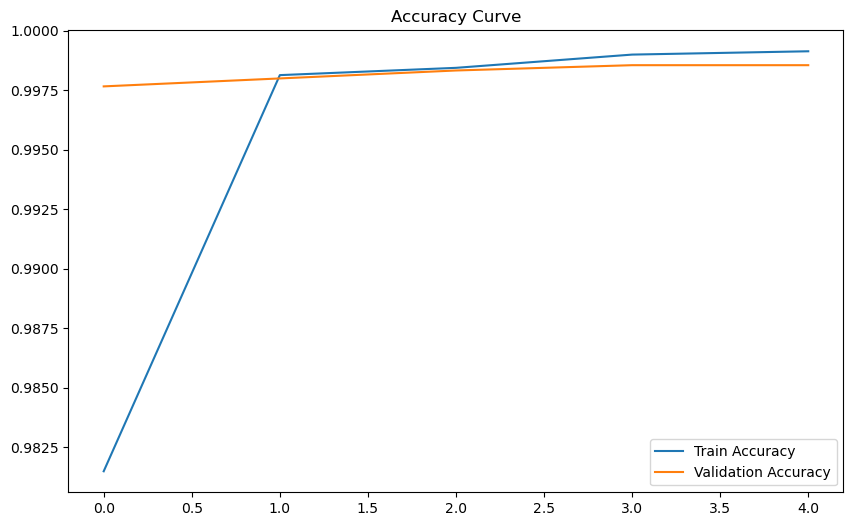

In [12]:
# Accuracy curve
plt.figure(figsize = (10,6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


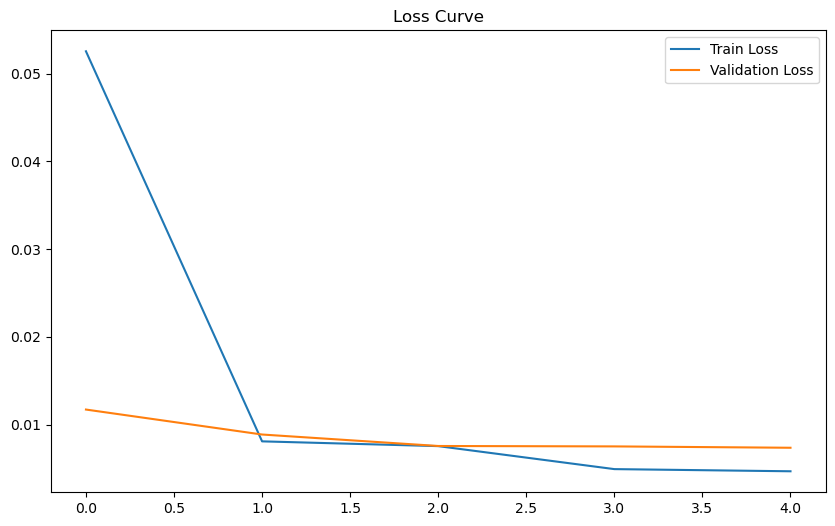

In [13]:
# Loss Curve
plt.figure(figsize = (10,6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

### Evaluation

In [14]:
loss, acc = model.model.evaluate(X_val_seq, y_val)
print(f"Loss: {loss} & Accuracy: {acc}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 52s 185ms/step - accuracy: 0.9986 - loss: 0.0074
Loss: 0.007355631794780493 & Accuracy: 0.9985523223876953


## Training Summary
- NLP preprocessing with NLTK
- Semantic representation using GloVe embeddings
- Bi-LSTM model for sequence learning